# ABOUT


Datascientest's Datascientist continuous bootcamp - cohorte Mars2022 -  AeroBOT project

**Tutor**

* Alban THUET

**Authors:**

* Hélène ASSIR

</br>

---
</br>

**Version History**

Version | Date       | Author(s)  | Modification
--------|----------- | ---------  | --------------------------
3.0     | 02/11/2022 | H.A.       | Code cleaning
2.0     | 30/09/2022 | H.A.       | Use df_for_Anomaly_prediction.pkl as data source 
1.0     | 24/08/2022 | H.A.       | Document creation

This notebook can be executed entirely. 

It

* mounts the GDrive of our AeroBot project @gmail account.

* loads the data from the `df_for_Anomaly_prediction.pkl` file (cf. `04_1_1 Anomaly feature Definition TRAIN set.ipynb`) under a pandas DataFrame named `df`, which contains `96986` entries and 20 columns.
These data do not contain any more UAS-related entries.

* Performs Anomaly target feature prediction : Bag Of Words approach with feature selection based on feature importance , for classifiers : Decision Tree, Random Forest and Gradient Boosting

# IMPORT PACKAGES


In [1]:
#######################
# Import packages
#######################
import numpy as np
import seaborn as sns
import math # for math.pi etc.
import time # time code execution

#######################
# Pandas
#######################
import pandas as pd
# Set pandas settings to show all data when using .head(), .columns etc.
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option("display.colheader_justify","left") # left-justify the print output of pandas

### Display full columnwidth
# Set pandas settings to display full text columns
#pd.options.display.max_colwidth = None
# Restore pandas settings to display standard colwidth
pd.reset_option('display.max_colwidth')

import itertools # Pour créer des iterateurs

# Package to show the progression of pandas operations
from tqdm import tqdm
# from tqdm.auto import tqdm  # for notebooks

# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()
# simply use .progress_apply() instead of .apply() on your pd.DataFram

######################
# PLOTTING
######################
import matplotlib.pyplot as plt
%matplotlib inline

#####################
# NLP 
#####################
import re # for Regular Expression handling
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet') # WordNet lemmatizer
nltk.download('omw-1.4') # necessary for WordNet lemmatizer
from nltk.tokenize import word_tokenize # Usual tokenizer
from nltk.tokenize import TweetTokenizer # Special tokenizer;  "we'll", "didn't", etc. are considered as one word
from sklearn.feature_extraction.text import CountVectorizer # Vectorization
from nltk.corpus import stopwords # Import stopwords from nltk.corpus
from nltk.stem.snowball import EnglishStemmer
##############################
# Undersampeling
##############################
from imblearn.under_sampling import RandomUnderSampler 
###############################
# ML preprocessing and models
###############################
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import ensemble # random forest
from sklearn.svm import SVC

from sklearn.metrics import classification_report, confusion_matrix


###############################
# Other
###############################
import pickle as pkl # Saving data externally

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


# LOAD DATA

## Mount GDrive

In [2]:
#@title
# Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive/')

#check your present working directory 
%pwd

Mounted at /content/drive/


'/content'

In [3]:
#@title
# move to the transformed data location (you can create a deeper structure, if needed, e.g. to save a trained model):
%cd /content/drive/MyDrive/data/transformed/

/content/drive/MyDrive/data/transformed


In [4]:
#@title
!ls # list the content of the pwd

#!ls "/content/drive/MyDrive/Data_Science/Formations/DataScienceTest/projet/AeroBot/" # list contect of a speficic folder

 complaints-2022-08-05_13_55.csv
'Copy of Qualified abbreviations_20220718.xlsx.gsheet'
'Data Dictionnary.xlsx'
 data_for_BERT_multilabel_20220805.pkl
 df_for_Anomaly_prediction.pkl
 df_test_for_Anomaly_prediction.pkl
 model.png
 model_results
 Narrative_PP_stemmed_24072022_TRAIN.pkl
 Narrative_Raw_Stemmed_24072022_TRAIN.pkl
 Narrative_RegEx_subst_21072022_TRAIN.pkl
'Qualified abbreviations_20220707_test.csv'
'Qualified abbreviations_20220708.csv'
'Qualified abbreviations_20220718.csv'
'Qualified abbreviations_20220718_Google_sheet.gsheet'
 STREAMLIT_demo_data
 test_data_final.pkl
 train_data_final.pkl


## Load data from .pkl file


In [5]:
# Load the TRAIN data (97417 entries)
# Do not touch the TEST data until the end of the project!
# or the curse of the greek gods will fall upon you!

%cd /content/drive/MyDrive/data/transformed/
with open("df_for_Anomaly_prediction.pkl", "rb") as f:
    loaded_data = pkl.load(f)

df = loaded_data
print("\nA Dataframe with", len(df), "entries has been loaded")

/content/drive/MyDrive/data/transformed

A Dataframe with 96986 entries has been loaded


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96986 entries, 1163382 to 874642
Data columns (total 20 columns):
 #   Column                                        Non-Null Count  Dtype 
---  ------                                        --------------  ----- 
 0   Narrative                                     96986 non-null  object
 1   Anomaly                                       96986 non-null  object
 2   Narrative_PP_stemmed                          96986 non-null  object
 3   Narrative_Raw_Stemmed                         96986 non-null  object
 4   Narrative_Raw_Stemmed_str                     96986 non-null  object
 5   Narrative_PP_stemmed_str                      96986 non-null  object
 6   Anomaly_Deviation / Discrepancy - Procedural  96986 non-null  int64 
 7   Anomaly_Aircraft Equipment                    96986 non-null  int64 
 8   Anomaly_Conflict                              96986 non-null  int64 
 9   Anomaly_Inflight Event / Encounter            96986 non-null  int

## Define Anomaly_RootLabels_columns list from data set

In [7]:
# Retriece the list of Anomaly label columns
Anomaly_RootLabels_columns = []

for col in df.columns:
  if 'Anomaly_' in str(col):
      Anomaly_RootLabels_columns.append(col)

In [8]:
Anomaly_RootLabels_columns

['Anomaly_Deviation / Discrepancy - Procedural',
 'Anomaly_Aircraft Equipment',
 'Anomaly_Conflict',
 'Anomaly_Inflight Event / Encounter',
 'Anomaly_ATC Issue',
 'Anomaly_Deviation - Altitude',
 'Anomaly_Deviation - Track / Heading',
 'Anomaly_Ground Event / Encounter',
 'Anomaly_Flight Deck / Cabin / Aircraft Event',
 'Anomaly_Ground Incursion',
 'Anomaly_Airspace Violation',
 'Anomaly_Deviation - Speed',
 'Anomaly_Ground Excursion',
 'Anomaly_No Specific Anomaly Occurred']

# SUPERVISED NARRATIVE PREPROCESSING WITH IMPORTANCE


## FIRST DECISION TREE PREDICTION

## STANDARD SAMPLING - Function metrics_table_DT  (DT classifiers only)
-Performs a decision tree model with standard sampling on the different targets and stock the results as well as the importance of features (tokens)

In [9]:
def metrics_table_DT(data, target, vectorizer, classifier):
    """
    Return Prediction metrics and feature importance for Decision Trees
    /!\ works only for DT, since the other models don't return Feature importance

    Inputs: 
    - data: pd.Series containing the narratives as single string
    - target: a list of target labels
    - vectorizer instance. Lets you instantiate it with the desired settings
    - classifier (must be a decision tree as we calculate importance)
    
    Return:
    - a DataFrame containing the classification reports for each target label
    - a DataFrame containing the feature importance for each token

    """

    # Time the function execution
    start_time = time.time()
    print(7*'-', "Execution started...", 7*'-', '\n')
    
    # Train-test split  
    X_train, X_test, y_train, y_test = train_test_split(data, target, 
                                                        test_size= 0.2, 
                                                        random_state = 12)


    # apply the vectorizer 
    X_train = vectorizer.fit_transform(X_train) 
    X_test = vectorizer.transform(X_test) 
    vocab = vectorizer.get_feature_names_out()
    print("Vocabulary length:" , len(vocab))

    # Instantiate variables
    df_importances = pd.DataFrame(vocab).rename(columns={0: 'token'})
    metrics_df_list = []

    # Loop through Anomaly labels
    for Anomaly in target.columns:

      print('Prediction of anomaly :', Anomaly)

      # Select the correct target data
      y_train_Anomaly = y_train[Anomaly]
      y_test_Anomaly = y_test[Anomaly]
     
      # Train & predict
      classifier.fit(X_train, y_train_Anomaly)
      y_pred = classifier.predict(X_test)

      #########  FEATURE IMPORTANCE ################
      # write feature and its importance into a dict
      feats={}
      for feature,importance in zip(vocab, classifier.feature_importances_):
        feats[feature] = importance

      # Create a DataFrame from the dict. Each anomaly label gets a new column
      col_importance = 'Importance_' + Anomaly
      importance = pd.DataFrame.from_dict(feats, orient = 'index').reset_index().rename(columns = {'index': 'token', 0: col_importance})
      df_importances = df_importances.merge(importance, on = 'token', how = 'left')

      #########  CLASSIFICATION REPORT #############
      # Classif. report; dict format
      clf_rep = classification_report(y_test_Anomaly, y_pred, output_dict = True)
      # write classification report dictionnary into pd.DataFrame
      metrics = pd.DataFrame(clf_rep).reset_index().rename(columns = {'index': 'metric'})
      # Fill in with anomaly name
      metrics['anomaly'] = Anomaly
      metrics['classifier'] = 'Decision Tree'  # [dt, rf, Word_Embedding, ...]
      metrics['undersampling'] = 0              # 1 if undersampling was applied
      metrics_df_list.append(metrics)

    
    metrics_exp = pd.concat(metrics_df_list)
    # Reset index, otherwise you get a repetition of 0,1,2,3
    metrics_exp = metrics_exp.reset_index().drop(columns =['index'])

    
    # Calculate and print time to execute
    end_time = time.time()
    print(f"--- DONE! It took {np.round((end_time - start_time)/60,1)} minutes ---")

    return metrics_exp, df_importances

### DT (Gini , Max_Depth=20), PP NARRATIVES,DEFAULT SAMPLING  (df_metrics_DT_PP.pkl)

In [10]:
# Initializes the objects necesseray function inputs
data = df['Narrative_PP_stemmed_str']
target = df[Anomaly_RootLabels_columns]
clf = DecisionTreeClassifier(max_depth = 20)
vectorizer = CountVectorizer() 

In [11]:
# Calls the function 
df_metrics, df_importances = metrics_table_DT(data, target, vectorizer, clf)

# Fill in additionnal columns with metadata
df_metrics['preprocessing'] = 1          # 0 if raw, 1 if preprocessed
df_metrics['Count_Vectorizer_opts'] = np.nan # ['exclude_numerics'; 'min_df = 12'; ...]
# Reorder columns
df_metrics = df_metrics[['classifier', 'preprocessing', 'undersampling', 'Count_Vectorizer_opts',
                'anomaly', 'metric', '0', '1', 'accuracy', 'macro avg', 'weighted avg']]

------- Execution started... ------- 

Vocabulary length: 50030
Prediction of anomaly : Anomaly_Deviation / Discrepancy - Procedural
Prediction of anomaly : Anomaly_Aircraft Equipment
Prediction of anomaly : Anomaly_Conflict
Prediction of anomaly : Anomaly_Inflight Event / Encounter
Prediction of anomaly : Anomaly_ATC Issue
Prediction of anomaly : Anomaly_Deviation - Altitude
Prediction of anomaly : Anomaly_Deviation - Track / Heading
Prediction of anomaly : Anomaly_Ground Event / Encounter
Prediction of anomaly : Anomaly_Flight Deck / Cabin / Aircraft Event
Prediction of anomaly : Anomaly_Ground Incursion
Prediction of anomaly : Anomaly_Airspace Violation
Prediction of anomaly : Anomaly_Deviation - Speed
Prediction of anomaly : Anomaly_Ground Excursion
Prediction of anomaly : Anomaly_No Specific Anomaly Occurred
--- DONE! It took 5.1 minutes ---


In [12]:
print(df_metrics.shape, " should be (56 , 11)")

(56, 11)  should be (56 , 11)


####Token Importance analysis

In [14]:
len(df_importances)

50030

In [15]:
df_metrics[df_metrics['metric'] == 'f1-score']

,classifier,preprocessing,undersampling,Count_Vectorizer_opts,anomaly,metric,0,1,accuracy,macro avg,weighted avg
2,Decision Tree,1,0,NaN,Anomaly_Deviation / Discrepancy - Procedural,f1-score,0.544830,0.760271,0.685947,0.652550,0.674230
6,Decision Tree,1,0,NaN,Anomaly_Aircraft Equipment,f1-score,0.868290,0.784764,0.836581,0.826527,0.835281
10,Decision Tree,1,0,NaN,Anomaly_Conflict,f1-score,0.927137,0.633509,0.878441,0.780323,0.874702
14,Decision Tree,1,0,NaN,Anomaly_Inflight Event / Encounter,f1-score,0.920059,0.573342,0.865347,0.746700,0.858662
18,Decision Tree,1,0,NaN,Anomaly_ATC Issue,f1-score,0.921196,0.506921,0.864110,0.714058,0.853602
22,Decision Tree,1,0,NaN,Anomaly_Deviation - Altitude,f1-score,0.954314,0.488847,0.916125,0.721581,0.912754
26,Decision Tree,1,0,NaN,Anomaly_Deviation - Track / Heading,f1-score,0.957865,0.461648,0.921848,0.709757,0.916680
30,Decision Tree,1,0,NaN,Anomaly_Ground Event / Encounter,f1-score,0.961553,0.450749,0.928137,0.706151,0.922475
34,Decision Tree,1,0,NaN,Anomaly_Flight Deck / Cabin / Aircraft Event,f1-score,0.974036,0.653860,0.951696,0.813948,0.949030
38,Decision Tree,1,0,NaN,Anomaly_Ground Incursion,f1-score,0.975579,0.565617,0.953758,0.770598,0.952839


In [16]:
# Prints the top 10 most important features for each Anomaly label
for Anomaly in target.columns:
  col_importance = 'Importance_' + Anomaly
  topfeatures = df_importances.sort_values(by = col_importance, ascending = False).head(5)
  print(Anomaly,'\n',topfeatures[['token', col_importance]], '\n')

Anomaly_Deviation / Discrepancy - Procedural 
       token    Importance_Anomaly_Deviation / Discrepancy - Procedural
20119   emerg  0.137034                                               
28691    land  0.035274                                               
37717  realiz  0.029505                                               
17851  declar  0.020620                                               
44219    told  0.017629                                                

Anomaly_Aircraft Equipment 
       token     Importance_Anomaly_Aircraft Equipment
30197  mainten  0.316409                             
20119    emerg  0.114091                             
20252    engin  0.076544                             
36970      qrh  0.043188                             
39308   runway  0.021098                              

Anomaly_Conflict 
       token      Importance_Anomaly_Conflict
44461   traffic  0.276328                   
37350        ra  0.073356                   
15936    collis 

In [17]:
topfeatures.head()

,token,Importance_Anomaly_Deviation / Discrepancy - Procedural,Importance_Anomaly_Aircraft Equipment,Importance_Anomaly_Conflict,Importance_Anomaly_Inflight Event / Encounter,Importance_Anomaly_ATC Issue,Importance_Anomaly_Deviation - Altitude,Importance_Anomaly_Deviation - Track / Heading,Importance_Anomaly_Ground Event / Encounter,Importance_Anomaly_Flight Deck / Cabin / Aircraft Event,Importance_Anomaly_Ground Incursion,Importance_Anomaly_Airspace Violation,Importance_Anomaly_Deviation - Speed,Importance_Anomaly_Ground Excursion,Importance_Anomaly_No Specific Anomaly Occurred
32858,night,0.000781,0.00034,0.0,0.00024,0.000000,0.000376,0.0,0.000229,0.0,0.0,0.0,0.0,0.0,0.052591
121,0200,0.000000,0.00000,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.038599
22244,four,0.000192,0.00000,0.0,0.00000,0.000287,0.000000,0.0,0.000336,0.0,0.0,0.0,0.0,0.0,0.037013
24560,hepa,0.000000,0.00000,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.035065
45994,unvaccin,0.000000,0.00000,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.035063


# Export data for STREAMLIT

In [41]:
topfeatures = df_importances.sort_values(by = col_importance, ascending = True).tail(10)

In [47]:
# Export as .csv
# %cd /content/drive/MyDrive/data/transformed/STREAMLIT_demo_data/
# df_importances.to_csv(r'df_importances_20230203.csv')

/content/drive/MyDrive/data/transformed/STREAMLIT_demo_data


In [48]:
# # Load .csv file
%cd /content/drive/MyDrive/data/transformed/STREAMLIT_demo_data/
!ls
df_importances = pd.read_csv('df_importances_20230203.csv').drop(columns = ['Unnamed: 0'])

baseline_vs_best_BERT_20221207.csv
df_importances_20230203.csv
model_results_diffBLM_bestmodel_1.csv
model_results_diffBLM_bestmodel_20221207.csv
model_results_diffBLM_bestmodel.csv
topfeatures_20230203.csv


## Plots GREEN version


<ipython-input-46-e140990d36fd>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,2))
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
<ipython-input-46-e140990d36fd>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the

<Figure size 288x144 with 0 Axes>

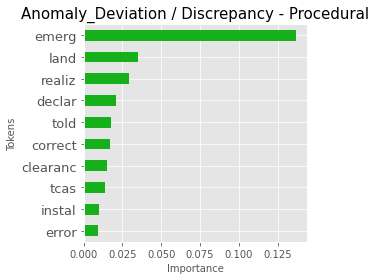

<Figure size 288x144 with 0 Axes>

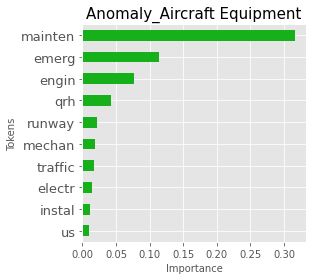

<Figure size 288x144 with 0 Axes>

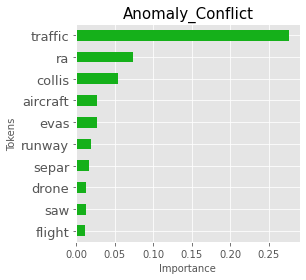

<Figure size 288x144 with 0 Axes>

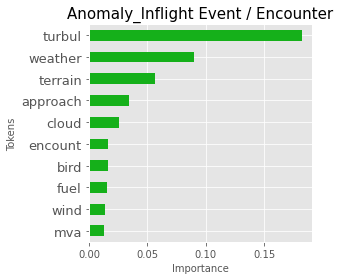

<Figure size 288x144 with 0 Axes>

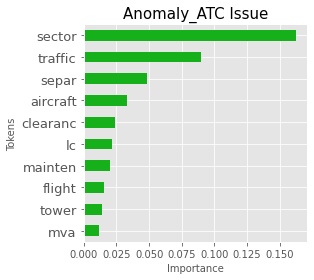

<Figure size 288x144 with 0 Axes>

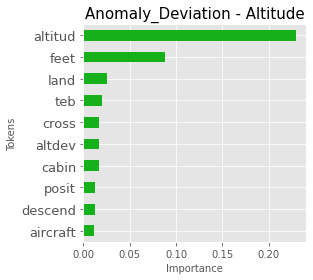

<Figure size 288x144 with 0 Axes>

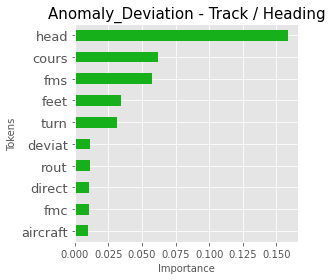

<Figure size 288x144 with 0 Axes>

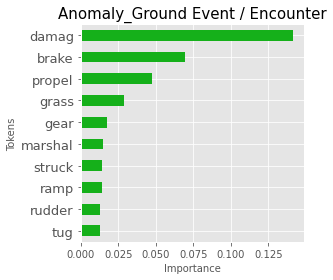

<Figure size 288x144 with 0 Axes>

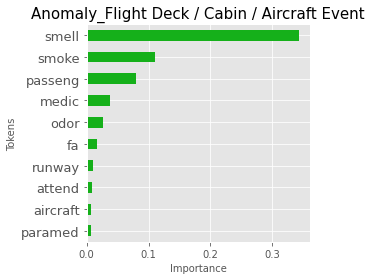

<Figure size 288x144 with 0 Axes>

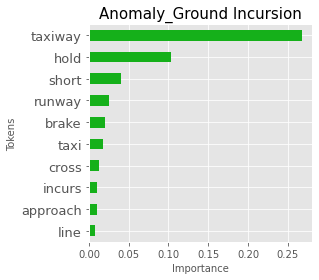

<Figure size 288x144 with 0 Axes>

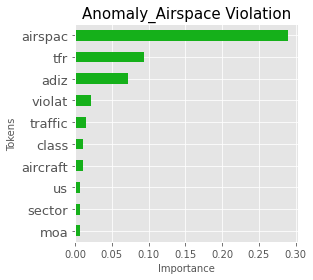

<Figure size 288x144 with 0 Axes>

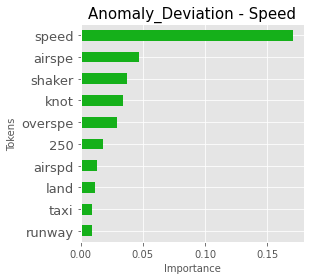

<Figure size 288x144 with 0 Axes>

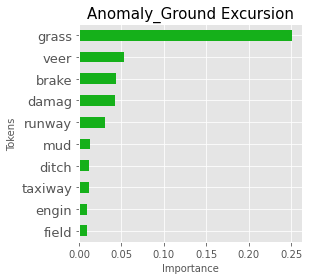

<Figure size 288x144 with 0 Axes>

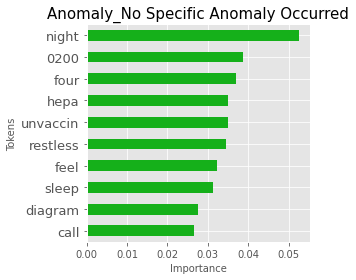

In [46]:
# Plots the top 10 most important features for each Anomaly label
for Anomaly in target.columns:
  col_importance = 'Importance_' + Anomaly
  topfeatures = df_importances.sort_values(by = col_importance, ascending = True).tail(10)
  fig = plt.figure(figsize=(4,2))
  plt.style.use('ggplot')
  plt.rcParams['axes.titlesize'] = 15
  plt.rcParams['axes.labelsize'] = 10
  plt.rcParams['xtick.labelsize'] = 10
  plt.rcParams['ytick.labelsize'] = 13
  topfeatures.set_index('token').plot.barh(y=[col_importance],color='#15B01A',legend=None,figsize=(4,4)) 
  plt.xlabel('Importance')
  plt.ylabel('Tokens')
  plt.title(Anomaly);